# Introduction

- Task: Multi-class Classification    
- Method: Deep Neural Network
- Library: PyTorch
- Dataset: FashionMnist
    - https://github.com/zalandoresearch/fashion-mnist
    - https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST
    - Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. 
    - Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    - Classes: {T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot}

# Set Environment

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./runs/Deep')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Selected device:", device)

torch.manual_seed(42)

Selected device: cuda


# Process Data

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST('/home/june/__github__/playground/data',
                                      download = True, train = True, transform = transform)

test_dataset = datasets.FashionMNIST('/home/june/__github__/playground/data',
                                     download = True, train = False, transform = transform)

100%|██████████| 26421880/26421880 [00:40<00:00, 655218.70it/s] 


Extracting /home/june/__github__/playground/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /home/june/__github__/playground/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 98840.52it/s]


Extracting /home/june/__github__/playground/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /home/june/__github__/playground/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:25<00:00, 174371.25it/s]


Extracting /home/june/__github__/playground/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /home/june/__github__/playground/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1342469.35it/s]

Extracting /home/june/__github__/playground/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/june/__github__/playground/data/FashionMNIST/raw



In [5]:
batch_size = 512

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,
                                          shuffle=True, num_workers = 0)

testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,
                                         shuffle = False, num_workers = 0)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [6]:
img, lbl = next(iter(trainloader))
img.shape, lbl.shape

(torch.Size([512, 1, 28, 28]), torch.Size([512]))

# Define Model

## Model Structure

In [7]:
class DeepClassifier(nn.Module):
    '''
    Multilayer classifier for batch input
    '''
    def __init__(self, input_size, hidden_size, num_classes):
        '''
        construct multiple fully connected layer

        Args:
            input_size: int
            hidden_size: int
            num_classes: int
        '''
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        '''
        forward pass through model

        Args:
            x(batched image): torch.Tensor, (batch_size, channel, width, height)

        Returns:
            x(logit): torch.Tensor, (batch_size, num_classes)
        '''
        x = x.view((x.size(0), -1))
        
        x = self.fc2(F.relu(self.fc1(x)))

        return x

## Hyperparameter & Functions

In [8]:
input_size = 28*28
hidden_size = 512
num_classes = 10

model = DeepClassifier(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
model.to(device)
criterion.to(device)

CrossEntropyLoss()

# Train

In [10]:
def train_model(model, criterion, optimizer, trainloader, num_epochs):
    print("-----Training Started------")
    for epoch in range(num_epochs):

        model.train()

        running_loss = 0.0
        
        for images, labels in tqdm(trainloader):
            
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        torch.save(model, './model/Deep.pth')
        
    print("-----Training Completed-----")

In [11]:
num_epochs = 16

train_model(model, criterion, optimizer, trainloader, num_epochs)
writer.flush()
writer.close()

-----Training Started------


100%|██████████| 118/118 [00:06<00:00, 18.55it/s]


Epoch [1/16], Loss: 0.5782


100%|██████████| 118/118 [00:06<00:00, 18.89it/s]


Epoch [2/16], Loss: 0.4083


100%|██████████| 118/118 [00:06<00:00, 18.70it/s]


Epoch [3/16], Loss: 0.3612


100%|██████████| 118/118 [00:06<00:00, 19.04it/s]


Epoch [4/16], Loss: 0.3390


100%|██████████| 118/118 [00:06<00:00, 18.86it/s]


Epoch [5/16], Loss: 0.3117


100%|██████████| 118/118 [00:06<00:00, 19.62it/s]


Epoch [6/16], Loss: 0.2960


100%|██████████| 118/118 [00:06<00:00, 19.43it/s]


Epoch [7/16], Loss: 0.2803


100%|██████████| 118/118 [00:06<00:00, 19.25it/s]


Epoch [8/16], Loss: 0.2665


100%|██████████| 118/118 [00:06<00:00, 19.61it/s]


Epoch [9/16], Loss: 0.2574


100%|██████████| 118/118 [00:06<00:00, 19.34it/s]


Epoch [10/16], Loss: 0.2488


100%|██████████| 118/118 [00:05<00:00, 19.82it/s]


Epoch [11/16], Loss: 0.2350


100%|██████████| 118/118 [00:05<00:00, 19.72it/s]


Epoch [12/16], Loss: 0.2275


100%|██████████| 118/118 [00:06<00:00, 19.13it/s]


Epoch [13/16], Loss: 0.2191


100%|██████████| 118/118 [00:06<00:00, 19.39it/s]


Epoch [14/16], Loss: 0.2122


100%|██████████| 118/118 [00:05<00:00, 19.76it/s]


Epoch [15/16], Loss: 0.2020


100%|██████████| 118/118 [00:05<00:00, 19.75it/s]

Epoch [16/16], Loss: 0.1983
-----Training Completed-----


# Test

In [12]:
def test_model(model, testloader):
    
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(testloader):
            
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy on test set: {accuracy:.4f}")

In [13]:
test_model(model, testloader)

100%|██████████| 20/20 [00:01<00:00, 19.67it/s]

Accuracy on test set: 0.8794


# Inference

In [14]:
import random

def random_sample(dataset, n):
    '''
    random sample n images from dataset

    Args:
        dataset: torchvision.datasets.cifar.CIFAR10
        n: int

    Returns:
        sampled_images: torch.tensor, (n, channel, width, height)
        sampled_labels: torch.tensor, (n)
    '''
    indices = random.sample(range(len(dataset)), n)
    
    sampled_images = torch.stack([dataset[i][0] for i in indices])
    sampled_labels = torch.tensor([dataset[i][1] for i in indices])

    return sampled_images, sampled_labels

In [15]:
def inference(model, images):
    '''
    forward pass through model, select class

    Args:
        model: LinearClassifier
        images: torch.tensor, (n, channel, width, height)

    Returns:
        predicted_labels: torch.tensor, (n)
    '''
    model.eval()

    with torch.no_grad():

        images = images.to(device)
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)
        
    return predicted_labels

In [16]:
def visualize(sampled_images, sampled_labels, predicted_labels):
    '''
    visualize image, labels, prediction by matplotlib.pyplot

    Args:
        sampled_images: torch.tensor, (n, channel, width, height)
        sampled_labels: torch.tensor, (n)
        predicted_labels: torch.tensor, (n)
    '''
    n = sampled_images.size(0)
    
    plt.figure(figsize=(15, 3))
    
    for i in range(n):
        plt.subplot(1, n, i + 1)
        image = sampled_images[i].permute(1, 2, 0)
        
        plt.imshow(image.numpy())
        plt.title(f"Label: {classes[sampled_labels[i].item()]}\nPred: {classes[predicted_labels[i].item()]}")
        plt.axis('off')
    
    plt.show()

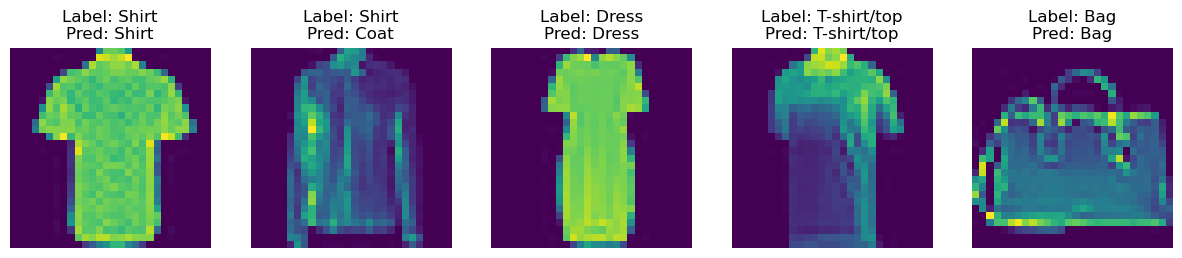

In [17]:
sampled_images, sampled_labels = random_sample(test_dataset, 5)
predicted_labels = inference(model, sampled_images)
visualize(sampled_images, sampled_labels, predicted_labels)